# ---Handwritten recognition system----

# Installing important packages

In [ ]:
! pip install tensorflow matplotlib # Install TensorFlow (for building, training, and using deep learning models)

In [124]:
! pip install opencv-python


# Import needed libraries

In [7]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


# Handwritten Digit Dataset Loader
This function loads grayscale images of handwritten digits from a directory structure where each subfolder is named after the digit it contains (e.g., 0, 1, ..., 9). Each image is resized and normalized before being added to the dataset, this is the link to the dataset being used https://universe.roboflow.com/popular-benchmarks/mnist-cjkff/dataset/3/download.

In [9]:
import os
import cv2
import numpy as np

def load_data(data_dir):
    X = []  # List to store image data
    y = []  # List to store corresponding labels

    # Loop through the subdirectories named 0–9
    for folder_name in sorted(os.listdir(data_dir)):
        folder_path = os.path.join(data_dir, folder_name)

        # Skip if it's not a directory (safety check)
        if not os.path.isdir(folder_path):
            continue

        # Convert folder name (e.g., "3") to an integer label (3)
        label = int(folder_name)

        # Loop through each image file in the digit folder
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)

            # Read the image in grayscale
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is not None:
                # Resize image to 28x28 pixels
                img = cv2.resize(img, (28, 28))

                # Normalize pixel values to [0, 1]
                img = img / 255.0

                # Append image and label to lists
                X.append(img)
                y.append(label)
            else:
                print(f"Warning: Couldn't read {img_path}")

    # Convert lists to numpy arrays for model compatibility
    return np.array(X), np.array(y)


# Data Preprocessing: Reshape, One-Hot Encode, and Shuffle
This section prepares the loaded MNIST digit images for training a convolutional neural network.

In [13]:
# Load training and testing data from local MNIST folder
X_train, y_train = load_data("/Users/nadaashraf/Downloads/MNIST/train")
X_test, y_test = load_data("/Users/nadaashraf/Downloads/MNIST/test")

# Reshape the data to add a channel dimension (needed for CNN input)
# New shape: (number_of_samples, 28, 28, 1)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# One-hot encode the labels to vectors of size 10
# Example: label 3 becomes [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Shuffle the training data to improve model generalization
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)


In [14]:
# Print the first 20 labels from the one-hot encoded training data
# np.argmax converts one-hot vectors back to their original class labels (0–9)
print("Train label distribution:", np.argmax(y_train, axis=1)[:20])


Train label distribution: [1 6 6 1 1 8 2 2 1 5 8 3 0 3 7 4 4 7 3 5]


# Splitting the Dataset and Training the Model with Validation

In this step, we split the 60,000 training images into 40,000 for training and 20,000 for validation. This helps us monitor the model’s performance and avoid overfitting.


In [16]:
from sklearn.model_selection import train_test_split

# Split 60,000 samples into 40,000 for training and 20,000 for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=20000, random_state=42, shuffle=True
)

# Show the new shapes to confirm
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

Training set shape: (40000, 28, 28, 1)
Validation set shape: (20000, 28, 28, 1)


# Visualizing Sample Images from the Training Set
This section displays a few sample handwritten digits from the training dataset along with their corresponding labels.

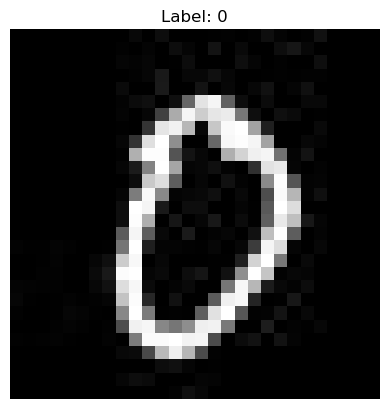

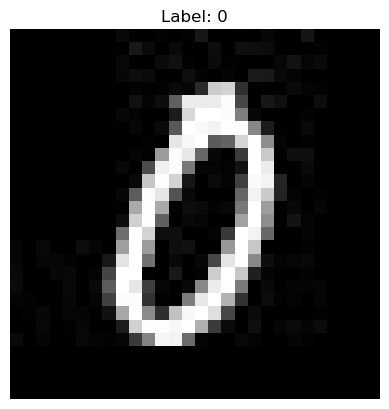

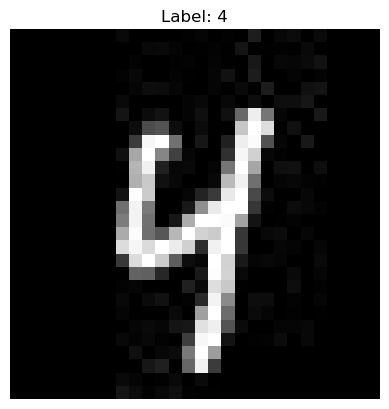

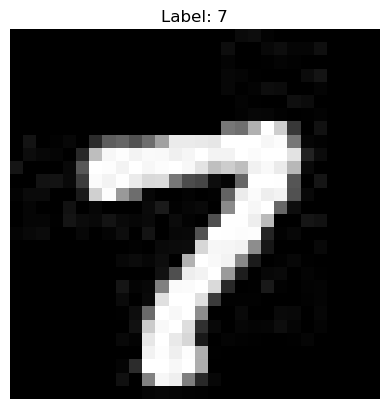

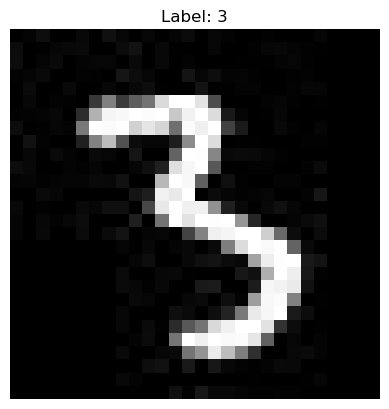

In [18]:
import matplotlib.pyplot as plt

# Display the first 5 images from the training set with their labels
for i in range(5):
    # Reshape the image back to 28x28 for visualization (remove channel dimension)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    
    # Set the title to show the actual label (converted from one-hot encoding)
    plt.title(f"Label: {np.argmax(y_train[i])}")
    
    # Hide axis ticks and labels for clarity
    plt.axis('off')
    
    # Display the image
    plt.show()


# Building the LeNet-5 Convolutional Neural Network Model
This section builds and compiles a CNN based on the classic LeNet-5 architecture, adapted for handwritten digit classification (MNIST dataset).

In [24]:
from tensorflow.keras import layers, models

# Define a sequential model
model = models.Sequential()

#LeNet-5 Inspired Architecture

# First convolutional layer: 6 filters of size 5x5, ReLU activation
model.add(layers.Conv2D(6, (5, 5), activation='relu', input_shape=(28, 28, 1)))

# First average pooling layer to reduce spatial dimensions
model.add(layers.AveragePooling2D(pool_size=(2, 2)))

# Second convolutional layer: 16 filters of size 5x5, ReLU activation
model.add(layers.Conv2D(16, (5, 5), activation='relu'))

# Second average pooling layer
model.add(layers.AveragePooling2D(pool_size=(2, 2)))

# Flatten the output to feed into the fully connected layers
model.add(layers.Flatten())

# First fully connected (dense) layer with 120 neurons
model.add(layers.Dense(120, activation='relu'))

# Second fully connected layer with 84 neurons
model.add(layers.Dense(84, activation='relu'))

# Output layer with 10 neurons (for digits 0–9), using softmax for probability distribution
model.add(layers.Dense(10, activation='softmax'))

#Model Compilation

# Compile the model with Adam optimizer and categorical cross-entropy loss
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Training the CNN Model
This section trains the LeNet-5 CNN model using the prepared training data and evaluates it on the validation set.

In [29]:
# epochs: number of times the model will iterate over the entire training set
# batch_size: number of samples per gradient update
# validation_data: data used to evaluate model performance after each epoch


model.fit(X_train, y_train,epochs=30,batch_size=128,validation_data=(X_val, y_val),  # Validation data used to monitor performance
    verbose=2  # Show detailed progress during training
)

Epoch 1/30
313/313 - 3s - 11ms/step - accuracy: 0.8459 - loss: 0.5292 - val_accuracy: 0.9349 - val_loss: 0.2216
Epoch 2/30
313/313 - 3s - 9ms/step - accuracy: 0.9458 - loss: 0.1810 - val_accuracy: 0.9602 - val_loss: 0.1306
Epoch 3/30
313/313 - 3s - 9ms/step - accuracy: 0.9633 - loss: 0.1192 - val_accuracy: 0.9701 - val_loss: 0.0998
Epoch 4/30
313/313 - 3s - 9ms/step - accuracy: 0.9736 - loss: 0.0888 - val_accuracy: 0.9751 - val_loss: 0.0814
Epoch 5/30
313/313 - 3s - 9ms/step - accuracy: 0.9770 - loss: 0.0744 - val_accuracy: 0.9754 - val_loss: 0.0787
Epoch 6/30
313/313 - 3s - 9ms/step - accuracy: 0.9804 - loss: 0.0638 - val_accuracy: 0.9779 - val_loss: 0.0709
Epoch 7/30
313/313 - 3s - 9ms/step - accuracy: 0.9823 - loss: 0.0564 - val_accuracy: 0.9801 - val_loss: 0.0624
Epoch 8/30
313/313 - 3s - 10ms/step - accuracy: 0.9850 - loss: 0.0498 - val_accuracy: 0.9825 - val_loss: 0.0574
Epoch 9/30
313/313 - 3s - 10ms/step - accuracy: 0.9858 - loss: 0.0459 - val_accuracy: 0.9822 - val_loss: 0.055

# Evaluating Model Performance on Test Data
This section evaluates the trained model on the test dataset to measure its accuracy and loss.

In [32]:
# Evaluate the trained model on the test dataset
# verbose=2 for clean, readable output
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

# Print the test accuracy and loss
print(f'Test accuracy: {test_acc}')
print(f'Test loss: {test_loss}')


313/313 - 1s - 2ms/step - accuracy: 0.9865 - loss: 0.0595
Test accuracy: 0.9865000247955322
Test loss: 0.05953458696603775


# Making Predictions on Test Images
This section demonstrates how to use the trained model to predict the class of a single image from the test set.

In [35]:
# Predict the class probabilities for all test images
predictions = model.predict(X_test)

# Get the predicted label for the first image in the test set
# - predictions[0] is a vector of class probabilities
# - .argmax() returns the index of the highest probability (i.e., predicted digit)
predicted_label = predictions[0].argmax()

# Display the predicted label
print(f'Predicted label: {predicted_label}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Predicted label: 0


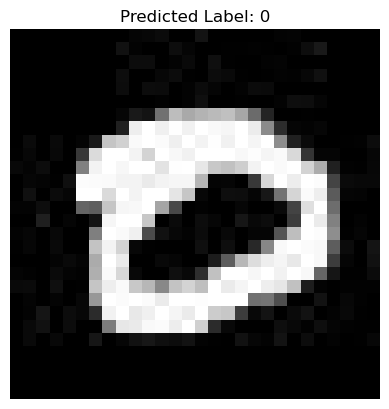

In [37]:
# displaying the image 
# Plot an example image from the test set
plt.imshow(X_test[0].reshape(28, 28), cmap='gray')  # Reshape to 28x28 to display
plt.title(f'Predicted Label: {predicted_label}')
plt.axis('off')
plt.show()


# Saving the Trained Model
This section saves the trained model to a file so that it can be loaded and used later without retraining.

In [40]:
# Save the model to a file
model.save('Desktop/handwritten_digit_model.h5')


# Testing Model on Custom Images
This section demonstrates how to preprocess and test the model on custom images that aren't part of the MNIST dataset and handle images that aren't in the same format.

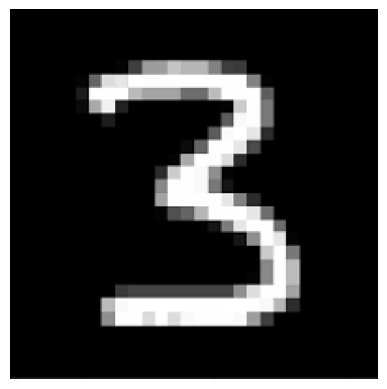

In [43]:
img_path= "Downloads/testing 3image.png"
img=cv2.imread(img_path)
image_rgb=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

#### Preprocessing the Custom Image for Model Prediction

In [46]:
# Function to preprocess the custom image
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # Read as grayscale
    img = cv2.resize(img, (28, 28)) # Resize to 28x28 (input size for the model)
    
    # Invert if background is white and digit is black
    if np.mean(img) > 127:  # If image is mostly bright
        img = 255 - img
    
    img = img / 255.0  # Normalize
    img = img.reshape(1, 28, 28, 1)  # Reshape for model
    return img

In [48]:
# Preprocess the custom image
img = preprocess_image("Downloads/testing 3image.png")

# Predict the digit using the trained model
pred = model.predict(img)

# Output the predicted digit
print(f"Predicted Digit: {np.argmax(pred)}")  # Use np.argmax to get the predicted class

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Digit: 3


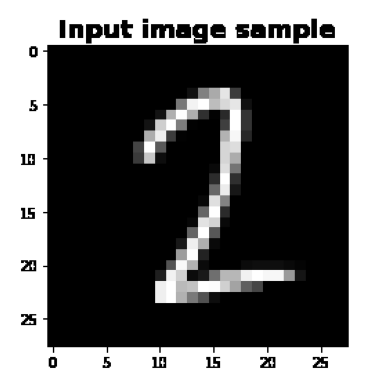

In [50]:
img_path= "Downloads/two.png"
img=cv2.imread(img_path)
image2_rgb=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image2_rgb)
plt.axis('off')
plt.show()

In [52]:
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (28, 28))
    
    # Invert if background is white and digit is black
    if np.mean(img) > 127:  # If image is mostly bright
        img = 255 - img
    
    img = img / 255.0  # Normalize
    img = img.reshape(1, 28, 28, 1)  # Reshape for model
    return img


In [54]:
img = preprocess_image("Downloads/two.png")
pred = model.predict(img)
print(f"Predicted Digit: {np.argmax(pred)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Digit: 2


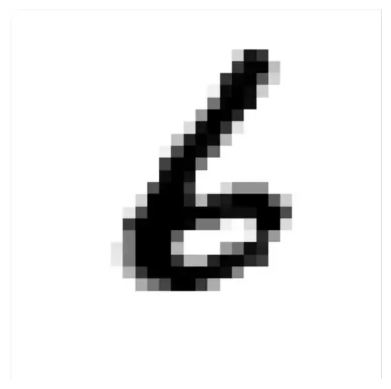

In [56]:
img_path= "Downloads/Ds5Rc.png"
image=cv2.imread(img_path)
image_rgb=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [58]:
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (28, 28))
    
    # Invert if background is white and digit is black
    if np.mean(img) > 127:  # If image is mostly bright
        img = 255 - img
    
    img = img / 255.0  # Normalize
    img = img.reshape(1, 28, 28, 1)  # Reshape for model
    return img



In [60]:
img = preprocess_image("Downloads/Ds5Rc.png")
pred = model.predict(img)
print(f"Predicted Digit: {np.argmax(pred)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted Digit: 6


# Visualizing the Processed Image
This section displays the grayscale, resized, normalized image after preprocessing—exactly how it’s fed into the model for prediction.

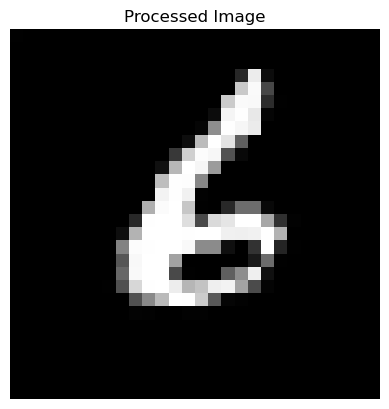

In [63]:
plt.imshow(img.reshape(28, 28), cmap='gray')
plt.title("Processed Image")
plt.axis('off')
plt.show()
